# <center>  SENTIMENT ANALYSIS</center>

WittyWicky Inc. is a consulting firm that designs brand strategy for a lot of product startups. Their modus operandi is to gain the pulse of competing products and the associated sentiment from social media. Social media has profound impact in capturing the potential customers and thus there are a lot of consulting firms that operate in the digital strategy space. Whether it is to design a marketing campaign or look at the effect of marketing campaigns on user engagement or sentiment, it is a very valuable tool.
Manual assessment of sentiment is very time consuming and automatic sentiment analysis would deliver a lot of value. As a team of data scientists consulting for WittyWicky Inc., you are now responsible for meeting their business outcomes.
### Problem Statement
Twitter has now become a useful way to build one's business as it helps in giving the brand a voice and a personality. The platform is also a quick, easy and inexpensive way to gain valuable insight from the desired audience. Identifying the sentiments about the product/brand can help the business take better actions.
You have with you evaluated tweets about multiple brands. The evaluators(random audience) were asked if the tweet expressed positive, negative, or no emotion towards a product/brand and labelled accordingly.
But this comes with several challenges. Primarily, the language used in this type of content is not strictly grammatically correct. We often come across people using sarcasm. Others cover several topics with different sentiments in one post. Other users post comments to indicate their sentiment around the topic.
Broadly speaking, sentiment can be clubbed into 4 major buckets – Positive, Negative, Neutral and Not sure Sentiments.

### Dataset Description
This dataset contains around 7k tweet text with the sentiment label.
The file train.csv has 3 columns
tweet_id - Unique id for tweets. tweet - Tweet about the brand/product sentiment - 0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell

### Evaluation Metric
We will be using ‘weighted’ F1-measure as the evaluation metric for this competition.

### Importing Common Libraries

In [45]:
#Import libraries and modules

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [46]:
#Import and Load Data
path_train = "./train.csv"
path_test = "./test.csv"
df_train = pd.read_csv(path_train)

In [47]:
df_train.head()

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of tou...,1
1,1851,Learning ab Google doodles! All doodles should...,1
2,2689,one of the most in-your-face ex. of stealing t...,2
3,4525,This iPhone #SXSW app would b pretty awesome i...,0
4,3604,Line outside the Apple store in Austin waiting...,1


In [48]:
df_train.head()

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of tou...,1
1,1851,Learning ab Google doodles! All doodles should...,1
2,2689,one of the most in-your-face ex. of stealing t...,2
3,4525,This iPhone #SXSW app would b pretty awesome i...,0
4,3604,Line outside the Apple store in Austin waiting...,1


In [49]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7274 entries, 0 to 7273
Data columns (total 3 columns):
tweet_id     7274 non-null int64
tweet        7273 non-null object
sentiment    7274 non-null int64
dtypes: int64(2), object(1)
memory usage: 170.6+ KB


In [50]:
df_test = pd.read_csv(path_test)

In [51]:
df_test.head()

,tweet_id,tweet
0,7506,Audience Q: What prototyping tools do you use?...
1,7992,At SXSW? Send Your Best Photos &amp; Videos to...
2,247,@mention and here's a pic of you winning your...
3,7688,Google Marissa Mayer: mobile phone as a cursor...
4,3294,#SXSW Google maps is even cooler than I thought


In [52]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1819 entries, 0 to 1818
Data columns (total 2 columns):
tweet_id    1819 non-null int64
tweet       1819 non-null object
dtypes: int64(1), object(1)
memory usage: 28.5+ KB


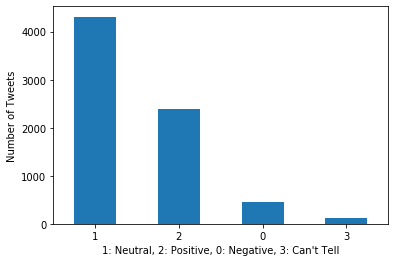

In [53]:
#Checking imbalance in train data
df_train['sentiment'].value_counts().plot(kind='bar')
plt.xlabel("1: Neutral, 2: Positive, 0: Negative, 3: Can't Tell", fontsize=10)
plt.xticks(rotation=0)
plt.ylabel('Number of Tweets', fontsize=10)
plt.show();

#### We can see from above plot that dataset is imbalanced. Hence we need to do sampling to obtain a balanced dataset for our final predictions.

### Word Cloud of Train Data before data cleaning and preprocessing

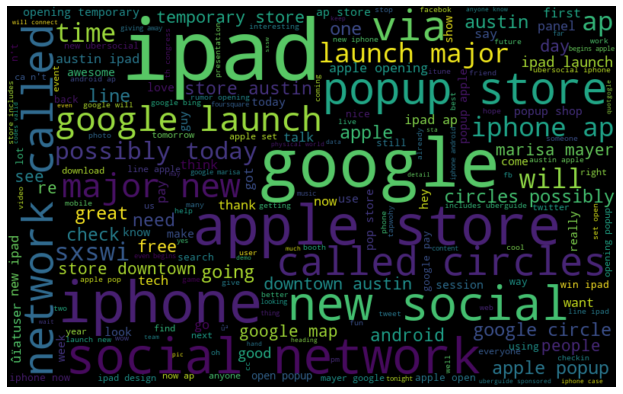

In [65]:
# Word Cloud of Train Data.
all_words = ' '.join([text for text in df_train['tweet']])

# generate wordcloud object for positive sentiments
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=110).generate(all_words)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show();

### Word Cloud of Test Data before data cleaning and preprocessing

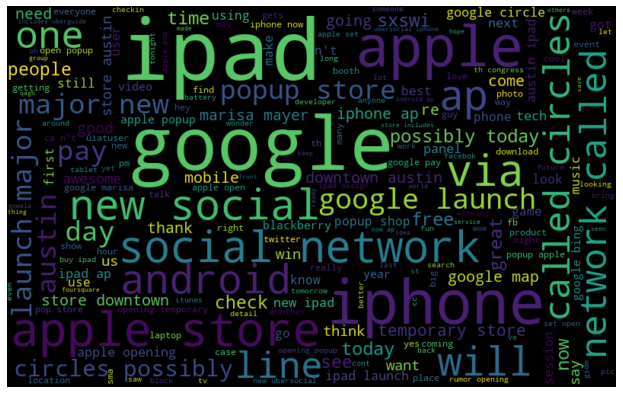

In [66]:
# Word Cloud of Test Data.
all_words = ' '.join([text for text in df_test['tweet']])

# generate wordcloud object for positive sentiments
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=110).generate(all_words)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show();

### Importing Libraries for Data Cleaning and Preprocessing

In [56]:
import re
import nltk
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import (wordnet, stopwords)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sufiy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data Cleaning and Preprocessing

In [57]:
def preprocessing_text(table):
    #put everything in lowercase
    table['tweet'] = table['tweet'].str.lower()
    #Replace rt indicating that was a retweet
    table['tweet'] = table['tweet'].str.replace('rt', '')
    #Replace occurences of mentioning @UserNames
    table['tweet'] = table['tweet'].replace(r'@[^\s]+', 'AT_USER', regex=True)
    #Replace links contained in the tweet
    table['tweet'] = table['tweet'].replace(r'((www\.[^\s]+)|(https?://[^\s]+))', 'URL', regex=True)
    #remove numbers
    table['tweet'] = table['tweet'].replace(r'[0-9]+', '', regex=True)
    #replace special characters and puntuation marks
    table['tweet'] = table['tweet'].replace(r'[!"$%&()*+,-./:;<=>?@[\]^_`{|}~]', '', regex=True)
    table['tweet'] = table['tweet'].replace(r'#([^\s]+)', r'\1', regex=True)
    return table

In [58]:
def stop_words(table):
    #We need to remove the stop words
    stop_words_list = ['english',"AT_USER","atuser","URL","rt","link","hashtags","amp","gt","quot","SXSW","sxsw","bit","ly"]
    table['tweet'] = table['tweet'].str.lower()
    table['tweet'] = table['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_list)]))
    return table

In [59]:
def in_dict(word):
    if wordnet.synsets(word):
        #if the word is in the dictionary, we'll return True
        return True

def replace_elongated_word(word):
    regex = r'(\w*)(\w+)\2(\w*)'
    repl = r'\1\2\3'    
    if in_dict(word):
        return word
    new_word = re.sub(regex, repl, word)
    if new_word != word:
        return replace_elongated_word(new_word)
    else:
        return new_word

def detect_elongated_words(row):
    regexrep = r'(\w*)(\w+)(\2)(\w*)'
    words = [''.join(i) for i in re.findall(regexrep, row)]
    for word in words:
        if not in_dict(word):
            row = re.sub(word, replace_elongated_word(word), row)
    return row

In [60]:
def replace_antonyms(word):
    #We get all the lemma for the word
    for syn in wordnet.synsets(word): 
        for lemma in syn.lemmas(): 
            #if the lemma is an antonyms of the word
            if lemma.antonyms(): 
                #we return the antonym
                return lemma.antonyms()[0].name()
    return word

In [61]:
def handling_negation(row):
    #Tokenize the row
    words = word_tokenize(row)
    speach_tags = ['JJ', 'JJR', 'JJS', 'NN', 'VB', 'VBD', 'VBG', 'VBN', 'VBP']
    #We obtain the type of words that we have in the text, we use the pos_tag function
    tags = nltk.pos_tag(words)
    #Now we ask if we found a negation in the words
    tags_2 = ''
    if "n't" in words and "not" in words:
        tags_2 = tags[min(words.index("n't"), words.index("not")):]
        words_2 = words[min(words.index("n't"), words.index("not")):]
        words = words[:(min(words.index("n't"), words.index("not")))+1]
    elif "n't" in words:
        tags_2 = tags[words.index("n't"):]
        words_2 = words[words.index("n't"):] 
        words = words[:words.index("n't")+1]
    elif "not" in words:
        tags_2 = tags[words.index("not"):]
        words_2 = words[words.index("not"):]
        words = words[:words.index("not")+1] 
        
    for index, word_tag in enumerate(tags_2):
        if word_tag[1] in speach_tags:
            words = words+[replace_antonyms(word_tag[0])]+words_2[index+2:]
            break
            
    return ' '.join(words)

In [62]:
def cleaning_table(table):
    #This function will process all the required cleaning for the text in our tweets
    table = preprocessing_text(table)
    table['tweet'] = table['tweet'].apply(lambda x: detect_elongated_words(x))
    table['tweet'] = table['tweet'].apply(lambda x: handling_negation(x))
    table = stop_words(table)
    return table

In [63]:
df_train.dropna(inplace=True)

In [64]:
df_train = cleaning_table(df_train)
df_test = cleaning_table(df_test)

#### We have successfully created dataframes with cleaned tweets

### Tokenizing and Stemming/Lemmmatizing Tweets

In [380]:
df_train['tokenized_tweet'] = [nltk.word_tokenize(x) for x in df_train['tweet']]
stemmer = SnowballStemmer('english')
df_train['tokenized_tweet'] = df_train['tokenized_tweet'].apply(lambda x: [stemmer.stem(i) for i in x])
df_train['tokenized_tweet'] = df_train['tokenized_tweet'].apply(lambda x: ' '.join(x))
df_train.head()

,tweet_id,tweet,sentiment,tokenized_tweet
0,1701,sxswnui sxsw apple defining language touch dif...,1,sxswnui sxsw appl defin languag touch differ d...
1,1851,learning ab google doodles doodles light funny...,1,learn ab googl doodl doodl light funni amp inn...
2,2689,one inyourface ex stealing show yrs atuser quo...,2,one inyourfac ex steal show yrs atus quotat sx...
3,4525,iphone sxsw ap would b pretty awesome n't cras...,0,iphon sxsw ap would b pretti awesom n't crash ...
4,3604,line outside apple store austin waiting new ip...,1,line outsid appl store austin wait new ipad sx...


In [381]:
df_test['tokenized_tweet'] = [nltk.word_tokenize(x) for x in df_test['tweet']]
stemmer = SnowballStemmer('english')
df_test['tokenized_tweet'] = df_test['tokenized_tweet'].apply(lambda x: [stemmer.stem(i) for i in x])
df_test['tokenized_tweet'] = df_test['tokenized_tweet'].apply(lambda x: ' '.join(x))
df_test.head()

,tweet_id,tweet,tokenized_tweet
0,7506,audience q protyping tools use sketchboksharpi...,audienc q protyp tool use sketchboksharpi pen ...
1,7992,sxsw send best photos amp videos link citizenj...,sxsw send best photo amp video link citizenjou...
2,247,atuser 's pic winning ipad unsix sxsw cc atuse...,atus 's pic win ipad unsix sxsw cc atus atus l...
3,7688,google marisa mayer mobile phone cursor physic...,googl marisa mayer mobil phone cursor physic l...
4,3294,sxsw google maps even cooler thought,sxsw googl map even cooler thought


### Importing Libraries for Vectorization and Predictions

In [383]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tfidf = TfidfVectorizer(stop_words="english", ngram_range=(1, 2))
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

### Vectorizing

In [432]:
vectorizer = CountVectorizer(stop_words=['english',"AT_USER","URL","rt","link","hashtags","amp","gt","quot","SXSW","sxsw","bit","ly"], ngram_range=(1,2))

In [433]:
X = df_train['tokenized_tweet']
y = df_train['sentiment']

In [434]:
X = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1993)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['at_user', 'url'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


### Top 20 Negative and Positive Words

In [450]:
w = vectorizer.get_feature_names()
coef = log_reg.coef_.tolist()[0]
coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
print('')
print('-Top 20 negative-')
print(coeff_df.head(20).to_string(index=False))
print('')
print('-Top 20 positive-')        
print(coeff_df.tail(20).to_string(index=False))


-Top 20 negative-
             Word  Coefficient
             fail     1.704063
             suck     1.649278
        atus line     1.554718
 atus quotmultipl     1.335787
         atus uxd     1.301226
            anoth     1.039812
           button     1.028603
   design headach     1.018842
       line ridic     1.009461
            ridic     1.009461
      delet iphon     1.002273
          headach     0.995195
        disapoint     0.994589
              boo     0.955390
            delet     0.945139
             seem     0.902052
          alreadi     0.892691
            guess     0.881661
     launch today     0.878057
      store insan     0.839275

-Top 20 positive-
        Word  Coefficient
        geek    -0.470181
 popup store    -0.473830
     network    -0.483166
       stare    -0.484524
       crazi    -0.486662
        next    -0.487200
 ûïatus atus    -0.522142
       stock    -0.530446
      around    -0.538305
          tr    -0.541535
     tr atus    -0.541535

## Predictions

### Baseline Prediction using Logistic Regression on Training Data

In [448]:
log_reg = LogisticRegression(random_state=1993, class_weight='balanced')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

0.6907928218936865
              precision    recall  f1-score   support

           0       0.59      0.34      0.43        77
           1       0.76      0.79      0.77       644
           2       0.61      0.63      0.62       358
           3       0.10      0.08      0.09        12

    accuracy                           0.70      1091
   macro avg       0.51      0.46      0.48      1091
weighted avg       0.69      0.70      0.69      1091



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Sampling

#### Sampling with Random Over Sampler

In [436]:
# Instantiate smote
sample = RandomOverSampler(random_state=1993)

# fit_sample on training data
X_sample, y_sample = sample.fit_sample(X_train, y_train)

#### Sampling with Tomek Links

In [437]:
# # Instantiate smote
# sample = TomekLinks()

# # fit_sample on training data
# X_sample, y_sample = sample.fit_sample(X_train, y_train)

### Post Sampling Predictions on Training Data

#### Logistic Regression

In [438]:
lr = LogisticRegression(random_state=1993, class_weight='balanced')
lr.fit(X_sample, y_sample)
y_pred = lr.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

0.6889802839882416
              precision    recall  f1-score   support

           0       0.61      0.32      0.42        77
           1       0.75      0.79      0.77       644
           2       0.61      0.62      0.61       358
           3       0.09      0.08      0.09        12

    accuracy                           0.69      1091
   macro avg       0.52      0.45      0.47      1091
weighted avg       0.69      0.69      0.69      1091



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### Random Forest Classifier

In [439]:
# Instantiate calssifier
rf_sample = RandomForestClassifier(random_state=1993)

# fit model on training data
rf_sample.fit(X_sample, y_sample)

#predicting on test data
y_pred = rf_sample.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

0.6547088433414532
              precision    recall  f1-score   support

           0       0.74      0.22      0.34        77
           1       0.71      0.82      0.76       644
           2       0.58      0.53      0.55       358
           3       0.00      0.00      0.00        12

    accuracy                           0.67      1091
   macro avg       0.51      0.39      0.41      1091
weighted avg       0.66      0.67      0.65      1091



#### Naive Bayes

In [440]:
from sklearn.naive_bayes import MultinomialNB

#Naive Bayes Model
nb = MultinomialNB()

nb.fit(X_sample, y_sample)

y_pred = nb.predict(X_test)

print(f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

0.6375595952577057
              precision    recall  f1-score   support

           0       0.36      0.45      0.40        77
           1       0.76      0.66      0.71       644
           2       0.55      0.61      0.58       358
           3       0.02      0.08      0.04        12

    accuracy                           0.62      1091
   macro avg       0.42      0.45      0.43      1091
weighted avg       0.66      0.62      0.64      1091



#### Support Vector Classifier

In [441]:
from sklearn.svm import LinearSVC

#Linear SVM Model
lsvm = LinearSVC(random_state=1993)

lsvm.fit(X_sample, y_sample)

y_pred = lsvm.predict(X_test)

print(f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

0.6808615773157118
              precision    recall  f1-score   support

           0       0.57      0.32      0.41        77
           1       0.75      0.80      0.77       644
           2       0.61      0.58      0.60       358
           3       0.00      0.00      0.00        12

    accuracy                           0.69      1091
   macro avg       0.48      0.43      0.45      1091
weighted avg       0.68      0.69      0.68      1091



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


#### XGBoost Classifier

In [442]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(base_estimator = lr, random_state = 1993)

xgb_clf.fit(X_sample, y_sample)

y_pred = xgb_clf.predict(X_test)

print(f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

0.593070732769998
              precision    recall  f1-score   support

           0       0.26      0.40      0.31        77
           1       0.75      0.62      0.68       644
           2       0.53      0.52      0.52       358
           3       0.01      0.08      0.02        12

    accuracy                           0.56      1091
   macro avg       0.39      0.40      0.38      1091
weighted avg       0.63      0.56      0.59      1091



#### AdaBoost Classifier

In [443]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(base_estimator = lr, random_state = 1993)

ada_clf.fit(X_sample, y_sample)

y_pred = ada_clf.predict(X_test)

print(f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

0.6009399022040544
              precision    recall  f1-score   support

           0       0.29      0.44      0.35        77
           1       0.73      0.66      0.69       644
           2       0.49      0.53      0.51       358
           3       0.00      0.00      0.00        12

    accuracy                           0.59      1091
   macro avg       0.38      0.41      0.39      1091
weighted avg       0.61      0.59      0.60      1091



#### Bagging Classifier

In [444]:
from sklearn.ensemble import BaggingClassifier

# Code starts here
bagging_clf = BaggingClassifier(base_estimator = LogisticRegression(), n_estimators = 100, max_samples = 100, random_state=1993)

bagging_clf.fit(X_sample, y_sample)

y_pred = bagging_clf.predict(X_test)

print(f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

0.5369003787679866
              precision    recall  f1-score   support

           0       0.20      0.39      0.27        77
           1       0.71      0.58      0.64       644
           2       0.44      0.43      0.43       358
           3       0.01      0.08      0.02        12

    accuracy                           0.51      1091
   macro avg       0.34      0.37      0.34      1091
weighted avg       0.58      0.51      0.54      1091



#### Stacking Classifier

In [445]:
from mlxtend.classifier import StackingClassifier

classifier1 = RandomForestClassifier(random_state=1993)
classifier2= LogisticRegression(random_state=1993)
classifier3 = LinearSVC(random_state=1993)
#classifier4= MultinomialNB()
classifier_list=[classifier1,classifier2,classifier3]

m_classifier=LogisticRegression(random_state=1993)

# Code starts here
sclf = StackingClassifier(classifiers = classifier_list, meta_classifier = m_classifier)

sclf.fit(X_sample, y_sample)

y_pred = sclf.predict(X_test)

print(f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.6504276593997228
              precision    recall  f1-score   support

           0       0.74      0.22      0.34        77
           1       0.71      0.81      0.76       644
           2       0.58      0.52      0.55       358
           3       0.00      0.00      0.00        12

    accuracy                           0.67      1091
   macro avg       0.51      0.39      0.41      1091
weighted avg       0.66      0.67      0.65      1091



### Vectorizing datasets for Final Prediction 

In [414]:
train=vectorizer.fit_transform(df_train.tokenized_tweet).toarray()
print(df_train.shape)
test=vectorizer.transform(df_test.tokenized_tweet).toarray()
print(df_test.shape)

(7273, 4)
(1819, 3)


In [415]:
y = df_train['sentiment']

### Final Prediction using Logistic Regression on Test Data

In [416]:
lr.fit(train, y)
y_pred_final = lr.predict(test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [417]:
submission = pd.DataFrame({"tweet_id": df_test["tweet_id"],"sentiment": y_pred_final})
submission.to_csv((r'C:\Users\sufiy\Desktop\Data Science\Hackathons\GreyAtom\Hackathon - 3\submission_35.csv'), index=False)

# THANK YOU